In [1]:
import zipfile
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from zipfile import ZipFile
from io import TextIOWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression   #regression 
from sklearn.linear_model import LogisticRegression #classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, ClassifierMixin, BaseEstimator
from sklearn.metrics import explained_variance_score, accuracy_score, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
#Loading the data in dataset_diabetes.zip, which contains a csv file into a dataframe
files = [] 

zf = ZipFile("dataset_diabetes.zip")
for info in zf.infolist():
    files.append(info.filename)
    
df_data = pd.read_csv(zf.open(files[0]))
df_map = pd.read_csv(zf.open(files[1]))

In [3]:
train = []
test = []

for i in range(len(df_data)):
    n1 = sum(int(digit) for digit in str(df_data.iloc[i]["encounter_id"]))
    n2 = sum(int(digit) for digit in str(df_data.iloc[i]["patient_nbr"]))
    total = n1 + n2 
    if total % 2 == 0:
        train.append(df_data.iloc[i][:])
    else:
        test.append(df_data.iloc[i][:])

In [4]:
train = pd.DataFrame(train)

In [5]:
test = pd.DataFrame(test)

In [6]:
#q1 Shapes of test and train dataframes
train.shape, test.shape

((50803, 50), (50963, 50))

In [7]:
#q2 Is time_in_hospital similar between test and training
(
    train["time_in_hospital"].mean(),
    test["time_in_hospital"].mean(),
    train["time_in_hospital"].std(), 
    test["time_in_hospital"].std(),
)

(4.401295199102416, 4.390695210250574, 2.984025665505041, 2.9862059667206435)

In [8]:
#q3 Is readmitted similar between test and training 
{
    "train": dict(train["readmitted"].value_counts()),
    "test": dict(test["readmitted"].value_counts()),
}

{'train': {'NO': 27360, '>30': 17770, '<30': 5673},
 'test': {'NO': 27504, '>30': 17775, '<30': 5684}}

In [9]:
#q4 How much data is missing in each column of the training set
missing_data_dict = {}
columns = list(train)
for i in range(len(columns)):
    NA = []
    non_NA = []
    for j in train[columns[i]]:
        if j == "?":
            NA.append(j)
        else:
            non_NA.append(j)
    if len(NA) != 0:
        total = len(non_NA) + len(NA)
        missing_data_dict[str(columns[i])] = len(NA) / (total) * 100
    else:
        continue

missing_data_dict

{'race': 2.2104993799578763,
 'weight': 96.80924354860933,
 'payer_code': 39.25949254965258,
 'medical_specialty': 49.180166525598885,
 'diag_1': 0.023620652323681674,
 'diag_2': 0.3444678463870244,
 'diag_3': 1.3955868747908586}

In [10]:
#q5 Which columns are of integer datatype 
int_columns = [] 
for i in range(len(columns)):
    string = str(type(train.iloc[0][columns[i]]))
    if "int" in string:
        int_columns.append(columns[i])
sorted(int_columns)


['admission_source_id',
 'admission_type_id',
 'discharge_disposition_id',
 'encounter_id',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'patient_nbr',
 'time_in_hospital']

In [11]:
#Reading 3 CSVs
admission_df = pd.read_csv("admission_type_id.csv")
discharge_df = pd.read_csv("discharge_disposition_id.csv")
ad_source_df = pd.read_csv("admission_source_id.csv")

In [12]:
#q6 How common are the pairins of admission_source_id and discharge_disposition_id
pd.set_option("display.max_columns", 999)

discharge_df.set_index("discharge_disposition_id")
ad_source_df.set_index("admission_source_id")
source = ad_source_df.set_index("admission_source_id")["description"]
discharge_df.set_index("discharge_disposition_id")["description"]
source_dict = dict(ad_source_df.set_index("admission_source_id")["description"])
dis_dict = dict(discharge_df.set_index("discharge_disposition_id")["description"])

source_df = pd.DataFrame(source)

for key in dis_dict:
    source_df[key] = 0 
del source_df["description"]

new_train = train[(train["admission_source_id"] != 0) & (train["discharge_disposition_id"] != 0)]

for i in range(len(new_train)):
    row = new_train.iloc[i]["admission_source_id"]
    col = new_train.iloc[i]["discharge_disposition_id"]
    source_df.loc[row, col] += 1 
    
source_df.dropna()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,30,27,28,29
admission_source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9356,204,1526,79,145,2029,45,19,4,1,117,1,48,32,21,0,0,473,0,1,0,367,76,2,133,0,0,0,27,0
2,319,3,30,8,9,87,1,6,0,0,11,0,1,0,0,0,0,52,0,0,0,13,2,1,0,0,0,0,2,0
3,27,2,5,0,2,21,0,0,0,0,1,0,0,0,0,0,0,41,0,0,0,1,0,0,0,0,0,0,0,0
4,843,49,87,11,28,258,3,5,0,0,23,0,4,2,0,0,0,229,0,0,0,21,5,0,5,0,0,0,1,0
5,20,4,277,5,7,25,0,0,0,0,20,0,3,2,0,0,0,58,0,0,0,4,6,0,1,0,0,1,0,0
6,730,17,189,64,44,23,6,0,0,0,8,0,1,0,0,0,0,12,0,0,0,10,3,0,0,0,0,0,0,0
7,17042,685,4128,250,311,3402,235,22,7,1,566,0,144,100,6,0,0,970,4,0,0,558,101,16,154,0,0,1,34,0
8,5,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,43,1,4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0


In [13]:
#q7 How common are the pairings of admission source to discharge disposition
df = source_df.rename(index = source_dict, columns = dis_dict)
df.drop("Not Available")

,Discharged to home,Discharged/transferred to another short term hospital,Discharged/transferred to SNF,Discharged/transferred to ICF,Discharged/transferred to another type of inpatient care institution,Discharged/transferred to home with home health service,Left AMA,Discharged/transferred to home under care of Home IV provider,Admitted as an inpatient to this hospital,Neonate discharged to another hospital for neonatal aftercare,Expired,Still patient or expected to return for outpatient services,Hospice / home,Hospice / medical facility,Discharged/transferred within this institution to Medicare approved swing bed,Discharged/transferred/referred another institution for outpatient services,Discharged/transferred/referred to this institution for outpatient services,NaN,"Expired at home. Medicaid only, hospice.","Expired in a medical facility. Medicaid only, hospice.","Expired, place unknown. Medicaid only, hospice.",Discharged/transferred to another rehab fac including rehab units of a hospital .,Discharged/transferred to a long term care hospital.,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,Not Mapped,Unknown/Invalid,Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere,Discharged/transferred to a federal health care facility.,Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,Discharged/transferred to a Critical Access Hospital (CAH).
admission_source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Physician Referral,9356,204,1526,79,145,2029,45,19,4,1,117,1,48,32,21,0,0,473,0,1,0,367,76,2,133,0,0,0,27,0
Clinic Referral,319,3,30,8,9,87,1,6,0,0,11,0,1,0,0,0,0,52,0,0,0,13,2,1,0,0,0,0,2,0
HMO Referral,27,2,5,0,2,21,0,0,0,0,1,0,0,0,0,0,0,41,0,0,0,1,0,0,0,0,0,0,0,0
Transfer from a hospital,843,49,87,11,28,258,3,5,0,0,23,0,4,2,0,0,0,229,0,0,0,21,5,0,5,0,0,0,1,0
Transfer from a Skilled Nursing Facility (SNF),20,4,277,5,7,25,0,0,0,0,20,0,3,2,0,0,0,58,0,0,0,4,6,0,1,0,0,1,0,0
Transfer from another health care facility,730,17,189,64,44,23,6,0,0,0,8,0,1,0,0,0,0,12,0,0,0,10,3,0,0,0,0,0,0,0
Emergency Room,17042,685,4128,250,311,3402,235,22,7,1,566,0,144,100,6,0,0,970,4,0,0,558,101,16,154,0,0,1,34,0
Court/Law Enforcement,5,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Not Available,43,1,4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0


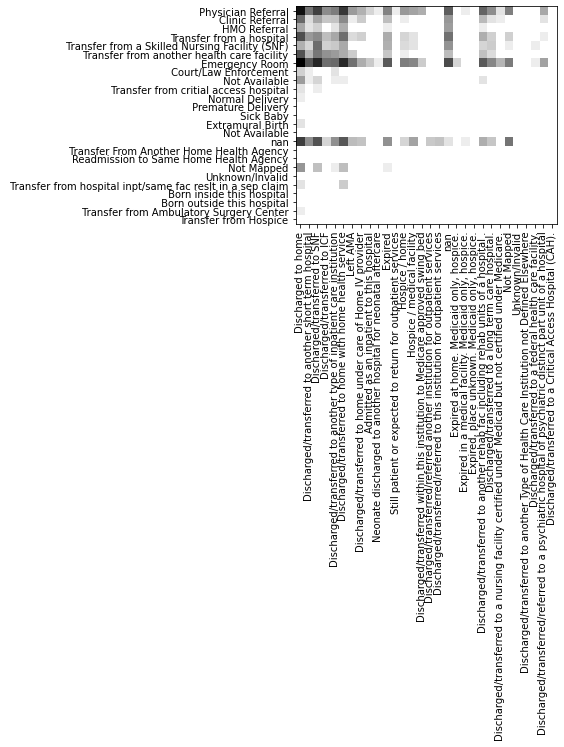

In [14]:
#q8 Making a heat map of the commonalities of pairings between admission source and discharge disposition
from math import * 
df = df.copy()

for i in range(len(df.index)):
    for j in range(len(df.columns)): 
        df.loc[df.index[i], df.columns[j]] += 1 
        df.loc[df.index[i], df.columns[j]] = log2(df.loc[df.index[i], df.columns[j]]) 


plt.imshow(df, cmap="binary")
plt.xticks(range(len(df.columns)),df.columns, rotation=90)
plt.yticks(range(len(df)),df.index)
plt.show()

In [15]:
def check_regression(ax):
    plot = {}
    plot["font12plus"] = min(ax.xaxis.label.get_size(),
                             ax.yaxis.label.get_size(),
                             ax.get_xticklabels()[0].get_size()) >= 12
    plot["transparency"] = ax.collections[0].get_alpha() != None
    plot["x-label"] = ax.get_xlabel().lower()
    plot["y-label"] = ax.get_ylabel().lower()
    plot["spines"] = ax.spines['right'].get_visible() or ax.spines['top'].get_visible()
    plot["x-mean"], plot["y-mean"] = ax.collections[0].get_offsets().data.std(axis=0)
    plot["x-std"], plot["y-std"] = ax.collections[0].get_offsets().data.mean(axis=0)
    plot["slope"] = None
    for line in ax.get_lines():
        x = line.get_xdata()
        y = line.get_ydata()
        for i in range(1, len(x)):
            slope = (y[i]-y[i-1]) / (x[i] - x[i-1])
            intercept = y[i] - x[i] * slope
            if plot["slope"] is None:
                plot["slope"] = slope
                plot["intercept"] = intercept
            elif not (np.isclose(plot["slope"], slope) and 
                      np.isclose(plot["intercept"], intercept)):
                plot["slope"] = None
                plot["intercept"] = None
                break
    return plot

{'font12plus': True,
 'transparency': True,
 'x-label': 'visits',
 'y-label': 'days in hospital',
 'spines': False,
 'x-mean': 2.2887866256900424,
 'y-mean': 2.983996296763971,
 'x-std': 1.206208294785741,
 'y-std': 4.401295199102416,
 'slope': 0.039510325255173874,
 'intercept': 4.353637517049942}

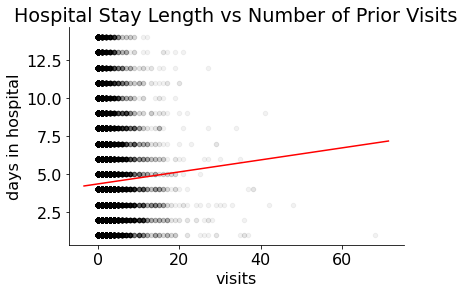

In [21]:
#q9 Plotting the relationship between number of prior visits and length of stay for the current visit 
train["visits"] = train["number_outpatient"] + train["number_inpatient"] + train["number_emergency"]
test["visits"] = test["number_outpatient"] + test["number_inpatient"] + test["number_emergency"]

lr = LinearRegression()
lr.fit(train[["visits"]], train["time_in_hospital"])
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
train.plot.scatter(x = "visits", y = "time_in_hospital", color = "k", alpha = 0.05, ax=ax)
ax.set_ylabel("days in hospital")
x = np.array(ax.get_xlim())
y = lr.predict(x.reshape(-1, 1))
ax.plot(x, y, c="red")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Hospital Stay Length vs Number of Prior Visits")
check_regression(ax)


In [22]:
#q10 How well does the regression perform on both the train and test datasets
(explained_variance_score(train["time_in_hospital"], lr.predict(train[["visits"]])),
explained_variance_score(test["time_in_hospital"], lr.predict(test[["visits"]])))

(0.0009184071670116367, 0.001087944356748527)

In [23]:
def range_mid(r):
    r = r.strip("[]()")
    return (int(r.split("-")[0]) + int(r.split("-")[1])) / 2 

class DemographicTransformer(TransformerMixin):
    def fit(self, train_df, y=None):
        self.race_columns = sorted(list(set(train_df["race"].values)))[1:]
        
        return self 
    
    def transform(self, df1):
        df2 = pd.DataFrame()
        
        for race in self.race_columns:
            df2[race] = (df1["race"] == race).astype(int)
            
        for gender in ["Female", "Male"]:
            df2[gender] = (df1["gender"] == gender).astype(int)
            
        df2["age"] = df1["age"].apply(range_mid)
        self.output_features_ = list(df2.columns)
        return df2
    

In [24]:
#q11 
DemographicTransformer().fit_transform(train).head()

,AfricanAmerican,Asian,Caucasian,Hispanic,Other,Female,Male,age
0,0,0,1,0,0,1,0,5.0
2,1,0,0,0,0,1,0,25.0
3,0,0,1,0,0,0,1,35.0
5,0,0,1,0,0,0,1,55.0
8,0,0,1,0,0,1,0,85.0


In [25]:
#https://stackoverflow.com/questions/20457038/how-to-round-to-2-decimals-with-python#:~:text=Just%20use%20the%20formatting%20with,rounding%20down%20to%202%20decimals.&text=You%20can%20use%20the%20round
#Source 

lr = LinearRegression()
pipe = Pipeline([
    ("dem", DemographicTransformer()), 
    ("lr", LinearRegression()),
])

y = "time_in_hospital"
pipe.fit(train, train[[y]])
output = "stay ="
for f, coef in zip(pipe["dem"].output_features_, np.nditer(pipe["lr"].coef_)):
    output += " " + f"{coef:.2f}" + "*" + str(f) + " +"
output += " " + str(pipe["lr"].intercept_[0].round(2))

In [26]:
#q12 What is the relationship between length of stay and the demographic data
output 

'stay = 0.32*AfricanAmerican + -0.29*Asian + 0.04*Caucasian + -0.14*Hispanic + -0.10*Other + 3.42*Female + 3.28*Male + 0.02*age + -0.45'

In [ ]:
#q13 How well does the output equation explain the variance 
(explained_variance_score(train["time_in_hospital"], pipe.predict(train)),
explained_variance_score(test["time_in_hospital"], pipe.predict(test)))


In [ ]:
#Using classification to predict a boolean variable indicating whether somebody will be readmitted within 30 days after being released
test["readmit_soon"] = test["readmitted"] == "<30"

train["readmit_soon"] = train["readmitted"] == "<30"

logr = LogisticRegression(solver = "lbfgs")

logr.fit(train[["time_in_hospital"]], train["readmit_soon"])

In [ ]:
class NaiveEstimator(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        if y.sum() / len(y) > 0.5:
            self.prediction = True
        else:
            self.prediction = False
    def predict(self, X):
        return [self.prediction] * len(X)
naive = NaiveEstimator()
naive.fit(train[["time_in_hospital"]], train["readmit_soon"])

In [ ]:
#q14 What is the accuracy of the classification
(accuracy_score(train["readmit_soon"], logr.predict(train[["time_in_hospital"]])),
accuracy_score(test["readmit_soon"], logr.predict(test[["time_in_hospital"]])))

In [ ]:
#q15 Rerunning the accuracy, except using a simpler estimator 
(accuracy_score(train["readmit_soon"], naive.predict(train[["time_in_hospital"]])),
accuracy_score(test["readmit_soon"], naive.predict(test[["time_in_hospital"]])))

In [ ]:
#q16 Confusion matric of the logistic regression
params = test[["time_in_hospital"]], test["readmit_soon"]
plot_confusion_matrix(logr, test[["time_in_hospital"]], test["readmit_soon"]).confusion_matrix.tolist()


In [ ]:
balanced_logr = LogisticRegression(solver="lbfgs", class_weight = "balanced")
balanced_logr.fit(train[["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency","number_inpatient"]], train["readmit_soon"])

In [ ]:
#q17 Confusion matric if we balance during fitting and consider more columns
plot_confusion_matrix(balanced_logr, test[["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency","number_inpatient"]], test["readmit_soon"]).confusion_matrix.tolist()


In [ ]:
neighbor = KNeighborsClassifier(n_neighbors = 3)
neighbor.fit(train[["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency","number_inpatient"]], train["readmit_soon"])

In [ ]:
#q18 Confusion matric if we try K-nearest neighbors 
plot_confusion_matrix(neighbor, test[["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency","number_inpatient"]], test["readmit_soon"]).confusion_matrix.tolist()
